# Import des librairies

In [1]:
#Main libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import datetime

In [2]:
#Embeddings

from sentence_transformers import util, SentenceTransformer

In [3]:
#deep learning

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

In [4]:
#Classifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [5]:
#Model selection

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from IPython.display import display

In [ ]:
#BERT for Sequence Classification

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

# Import des données

In [6]:
data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [7]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
data.shape

(7613, 5)

In [9]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Split training data and validation data

In [10]:
train_data, val_data = train_test_split(data, test_size=0.1)

In [11]:
train_data.shape

(6851, 5)

In [12]:
val_data.shape

(762, 5)

### Resetting index

In [13]:
train_data.reset_index(drop=True, inplace=True)

In [14]:
train_data.head()

,id,keyword,location,text,target
0,10810,wrecked,6,@Tunes_WGG lol. U got wrecked,0
1,313,annihilated,NaN,Cop pulls drunk driver to safety SECONDS befor...,1
2,1607,bombed,MY RTs ARE NOT ENDORSEMENTS,@ChristophersZen @HunterLove1995 @tblack yeah ...,0
3,589,arson,NaN,Tennessee lesbian couple faked hate crime and ...,1
4,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,1


In [15]:
val_data.reset_index(drop=True, inplace=True)

### Separating X and target

In [16]:
X_train = train_data['text']

In [17]:
y_train = train_data['target']

In [18]:
X_val = val_data['text']

In [19]:
y_val = val_data['target']

# Data Engineering

In [20]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
data.keyword.isna().sum()

61

In [22]:
data.location.isna().sum()

2533

In [23]:
l_full_text = []

for i in range(data.shape[0]):
    full_text = data['text'][i]
    if str(data['keyword'][i]) != 'nan':
        full_text += f' #{data["keyword"][i]}'
    if str(data['location'][i]) != 'nan':
        full_text += f' #{data["location"][i]}'

    l_full_text.append(full_text)

In [24]:
data['full_text'] = pd.Series(l_full_text)

In [25]:
data.head()

,id,keyword,location,text,target,full_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


Après quelques essais, les embeddings de full_text offrent de moins bons résultats de prédiction que ceux du texte simple.

# Sentence Embeddings

In [26]:
transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [27]:
embeddings = transformer.encode(X_train)

In [28]:
embeddings.shape

(6851, 768)

In [29]:
val_embeddings = transformer.encode(X_val)

# Deep Learning Model

### Convert embeddings and target to tensors

In [30]:
tensor_embeddings = tf.convert_to_tensor(embeddings)
tensor_y = tf.convert_to_tensor(y_train)

Metal device set to: Apple M1


2022-08-29 17:44:19.563600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-29 17:44:19.563717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
tensor_embeddings.shape

TensorShape([6851, 768])

In [32]:
tensor_y.shape

TensorShape([6851])

In [33]:
tensor_val_embeddings = tf.convert_to_tensor(val_embeddings)
tensor_val_y = tf.convert_to_tensor(y_val)

### Define model architecture

In [34]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [35]:
optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

In [36]:
model = Sequential()

# Define model architecture.
model.add(Dense(728, input_shape=(768,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 728)               559832    
                                                                 
 dropout (Dropout)           (None, 728)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               186624    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [38]:
model.compile(
    optimizer=optimizer, #or optimizer
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

### Training and performances visualization

In [39]:
history = model.fit(
    x=tensor_embeddings,
    y=tensor_y,
    validation_data=(tensor_val_embeddings, tensor_val_y),
    callbacks=[learning_rate_reduction],
    epochs = 20)

Epoch 1/20


2022-08-29 17:44:19.698334: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-29 17:44:19.896703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 8ms/step - loss: 0.4461 - accuracy: 0.8062 - val_loss: 0.4457 - val_accuracy: 0.8084 - lr: 0.0010
Epoch 2/20
  1/215 [..............................] - ETA: 2s - loss: 0.2819 - accuracy: 0.8750

2022-08-29 17:44:21.752529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 8ms/step - loss: 0.3811 - accuracy: 0.8419 - val_loss: 0.4610 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 2s 9ms/step - loss: 0.3366 - accuracy: 0.8577 - val_loss: 0.4710 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 2s 8ms/step - loss: 0.2954 - accuracy: 0.8758 - val_loss: 0.5309 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 2s 8ms/step - loss: 0.2411 - accuracy: 0.8987 - val_loss: 0.6535 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 6/20
211/215 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9196
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 2s 8ms/step - loss: 0.1927 - accuracy: 0.9199 - val_loss: 0.6325 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 2s 8ms/step - loss: 0

In [40]:
def plot_training_results(history, model_name):
    
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    
    epochs_nb = history.params['epochs']
    
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.set_title(f'Loss history of {model_name} over {epochs_nb} epochs')
    ax_loss.set_xlabel('Number of epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax_acc.set_title(f'Accuracy history of {model_name} over {epochs_nb} epochs')
    ax_acc.set_xlabel('Number of epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

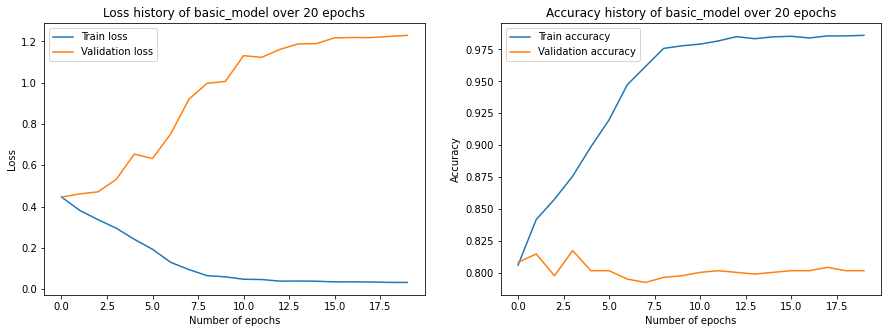

In [41]:
plot_training_results(history, 'basic_model')

# Classifier approaches 

### RandomForestClassifier

In [42]:
rfc = RandomForestClassifier(verbose=1)

In [43]:
rfc.fit(embeddings, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished


RandomForestClassifier(verbose=1)

In [44]:
rfc.score(embeddings, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


0.997372646329003

In [45]:
rfc.score(val_embeddings, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.7965879265091863

### GradientBoostingClassifier

In [46]:
gbc = GradientBoostingClassifier(verbose=1)

In [47]:
gbc.fit(embeddings, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3189            1.74m
         2           1.2801            1.72m
         3           1.2448            1.70m
         4           1.2127            1.68m
         5           1.1824            1.67m
         6           1.1562            1.65m
         7           1.1316            1.63m
         8           1.1093            1.61m
         9           1.0884            1.59m
        10           1.0700            1.58m
        20           0.9328            1.40m
        30           0.8509            1.24m
        40           0.7958            1.07m
        50           0.7534           53.57s
        60           0.7201           43.05s
        70           0.6917           32.39s
        80           0.6678           21.76s
        90           0.6485           10.93s
       100           0.6313            0.00s


GradientBoostingClassifier(verbose=1)

In [48]:
gbc.score(embeddings, y_train)

0.8766603415559773

In [49]:
gbc.score(val_embeddings, y_val)

0.8175853018372703

# Hyperparameters tuning

In [50]:
param_grid = { 'n_estimators': [100, 300, 500, 1000],
               'max_depth': [300, 500, 1000]
              }

### RandomForestClassifier

In [51]:
grid = GridSearchCV(RandomForestClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   8.0s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   7.8s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   7.9s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   7.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   7.7s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  23.5s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  23.2s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  22.9s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  22.9s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  23.2s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=500; total time=  38.9s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=500; total time=  38.8s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   39.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=500; total time=  39.1s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=500; total time=  38.8s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


[CV] END ....................max_depth=300, n_estimators=500; total time=  38.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ...................max_depth=300, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ...................max_depth=300, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ...................max_depth=300, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ...................max_depth=300, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=300, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=   7.7s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=   7.9s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=   7.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=   7.8s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=100; total time=   7.7s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  23.1s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  23.3s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  22.8s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  22.9s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=300; total time=  23.5s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=500; total time=  38.7s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=500; total time=  38.9s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=500; total time=  38.2s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   37.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=500; total time=  38.0s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=500, n_estimators=500; total time=  38.1s


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ...................max_depth=500, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ...................max_depth=500, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ...................max_depth=500, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 20.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ...................max_depth=500, n_estimators=1000; total time=20.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 18.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=500, n_estimators=1000; total time=18.4min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=   7.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 11.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=11.6min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=   7.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=   7.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=100; total time=   7.6s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 16.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=16.4min


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  22.7s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  22.3s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 17.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=17.9min


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=300; total time=  22.5s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 17.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=500; total time=17.0min


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   37.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=500; total time=  37.8s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 16.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=500; total time=16.3min


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 16.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=500; total time=16.6min


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 15.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ...................max_depth=1000, n_estimators=500; total time=15.4min


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.2s finished


[CV] END ..................max_depth=1000, n_estimators=1000; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   50.1s finished


GridSearchCV(estimator=RandomForestClassifier(verbose=1),
             param_grid={'max_depth': [300, 500, 1000],
                         'n_estimators': [100, 300, 500, 1000]},
             verbose=2)

In [52]:
grid.best_params_

{'max_depth': 1000, 'n_estimators': 500}

In [53]:
grid.best_estimator_.score(val_embeddings, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


0.8044619422572179

### GradientBoostingClassifier

Due to the time of computing needed to run GridSearchCV on GradientBoostingClassifier with our param_grid, we are going to use HalvingGridSearchCV.

In [ ]:
grid = HalvingGridSearchCV(GradientBoostingClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 761
max_resources_: 6851
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 761
Fitting 5 folds for each of 12 candidates, totalling 60 fits
      Iter       Train Loss   Remaining Time 
         1           1.1945           16.12s
         2           1.0389           15.69s
         3           0.9093           15.57s
         4           0.7998           15.14s
         5           0.7062           14.96s
         6           0.6256           14.74s
         7           0.5557           14.65s
         8           0.4948           14.42s
         9           0.4414           14.22s
        10           0.3944           14.04s
        20           0.1353           12.21s
        30           0.0486           10.66s
        40           0.0177            9.10s
        50           0.0065            7.58s
        60           0.0024            6.06s
        70        

       200           0.0000           16.40s
       300           0.0000            0.00s
[CV] END ....................max_depth=300, n_estimators=300; total time=  32.8s
      Iter       Train Loss   Remaining Time 
         1           1.1872           50.27s
         2           1.0321           49.29s
         3           0.9031           47.94s
         4           0.7941           48.39s
         5           0.7011           49.67s
         6           0.6211           48.71s
         7           0.5516           48.11s
         8           0.4911           47.54s
         9           0.4381           47.69s
        10           0.3914           47.68s
        20           0.1342           45.00s
        30           0.0482           43.60s
        40           0.0176           42.20s
        50           0.0065           40.62s
        60           0.0024           38.98s
        70           0.0009           37.42s
        80           0.0003           35.66s
        90        

         2           1.0389            2.68m
         3           0.9093            2.71m
         4           0.7998            2.65m
         5           0.7062            2.64m
         6           0.6256            2.62m
         7           0.5557            2.62m
         8           0.4948            2.60m
         9           0.4414            2.59m
        10           0.3944            2.58m
        20           0.1353            2.50m
        30           0.0486            2.45m
        40           0.0177            2.43m
        50           0.0065            2.40m
        60           0.0024            2.37m
        70           0.0009            2.34m
        80           0.0003            2.31m
        90           0.0001            2.29m
       100           0.0000            2.26m
       200           0.0000            1.76m
       300           0.0000            1.03m
       400           0.0000           39.70s
       500           0.0000           26.47s
       600

        10           0.3924           15.63s
        20           0.1376           13.70s
        30           0.0523           12.03s
        40           0.0220           10.29s
        50           0.0110            8.54s
        60           0.0069            6.84s
        70           0.0054            5.12s
        80           0.0049            3.42s
        90           0.0047            1.71s
       100           0.0046            0.00s
[CV] END ....................max_depth=500, n_estimators=100; total time=  17.1s
      Iter       Train Loss   Remaining Time 
         1           1.1723           18.94s
         2           1.0181           20.19s
         3           0.8903           19.32s
         4           0.7826           19.61s
         5           0.6907           19.64s
         6           0.6117           19.56s
         7           0.5433           19.03s
         8           0.4836           18.64s
         9           0.4314           18.22s
        10        

        10           0.3846           52.78s
        20           0.1319           48.71s
        30           0.0474           46.16s
        40           0.0173           44.26s
        50           0.0063           43.04s
        60           0.0023           40.85s
        70           0.0009           39.24s
        80           0.0003           37.51s
        90           0.0001           35.72s
       100           0.0000           33.91s
       200           0.0000           14.69s
       300           0.0000            0.00s
[CV] END ....................max_depth=500, n_estimators=300; total time=  29.4s
      Iter       Train Loss   Remaining Time 
         1           1.1945            1.34m
         2           1.0389            1.31m
         3           0.9093            1.34m
         4           0.7998            1.31m
         5           0.7062            1.30m
         6           0.6256            1.29m
         7           0.5557            1.29m
         8        

         9           0.4386            2.87m
        10           0.3924            2.88m
        20           0.1376            2.82m
        30           0.0523            2.79m
        40           0.0220            2.76m
        50           0.0110            2.72m
        60           0.0069            2.70m
        70           0.0054            2.66m
        80           0.0049            2.64m
        90           0.0047            2.61m
       100           0.0046            2.58m
       200           0.0046            2.13m
       300           0.0046            1.57m
       400           0.0046            1.23m
       500           0.0046           59.13s
       600           0.0046           45.52s
       700           0.0046           33.37s
       800           0.0046           21.78s
       900           0.0046           10.88s
      1000           0.0046            0.00s
[CV] END ...................max_depth=500, n_estimators=1000; total time= 7.2min
      Iter       Tr

         4           0.7941           15.13s
         5           0.7011           15.58s
         6           0.6211           15.21s
         7           0.5516           14.97s
         8           0.4911           14.95s
         9           0.4381           14.89s
        10           0.3914           14.80s
        20           0.1342           12.95s
        30           0.0482           11.39s
        40           0.0176            9.81s
        50           0.0065            8.21s
        60           0.0024            6.56s
        70           0.0009            4.93s
        80           0.0003            3.28s
        90           0.0001            1.64s
       100           0.0000            0.00s
[CV] END ...................max_depth=1000, n_estimators=100; total time=  16.3s
      Iter       Train Loss   Remaining Time 
         1           1.1702           23.56s
         2           1.0162           21.02s
         3           0.8885           21.07s
         4        

         1           1.1821            1.51m
         2           1.0279            1.46m
         3           0.8997            1.46m
         4           0.7916            1.45m
         5           0.6994            1.44m
         6           0.6200            1.43m
         7           0.5512            1.43m
         8           0.4912            1.42m
         9           0.4386            1.42m
        10           0.3924            1.42m
        20           0.1376            1.38m
        30           0.0523            1.35m
        40           0.0220            1.32m
        50           0.0110            1.29m
        60           0.0069            1.26m
        70           0.0054            1.23m
        80           0.0049            1.21m
        90           0.0047            1.18m
       100           0.0046            1.15m
       200           0.0046           48.23s
       300           0.0046           26.75s
       400           0.0046           12.19s
       500

       100           0.0000            2.90m
       200           0.0000            2.22m
       300           0.0000            1.30m
       400           0.0000           49.97s
       500           0.0000           33.32s
       600           0.0000           22.22s
       700           0.0000           14.29s
       800           0.0000            8.34s
       900           0.0000            3.71s
      1000           0.0000            0.00s
[CV] END ..................max_depth=1000, n_estimators=1000; total time=  33.4s
      Iter       Train Loss   Remaining Time 
         1           1.1872            2.73m
         2           1.0321            2.71m
         3           0.9031            2.67m
         4           0.7941            2.65m
         5           0.7011            2.65m
         6           0.6211            2.62m
         7           0.5516            2.62m
         8           0.4911            2.61m
         9           0.4381            2.63m
        10        

         3           0.8970            6.27m
         4           0.7886            6.18m
         5           0.6962            6.18m
         6           0.6166            6.13m
         7           0.5477            6.09m
         8           0.4876            6.07m
         9           0.4349            6.09m
        10           0.3886            6.06m
        20           0.1333            5.85m
        30           0.0479            5.63m
        40           0.0175            5.50m
        50           0.0064            5.37m
        60           0.0024            5.26m
        70           0.0009            5.13m
        80           0.0003            5.02m
        90           0.0001            4.90m
       100           0.0000            4.78m
       200           0.0000            3.12m
       300           0.0000            1.39m
       400           0.0000           31.22s
       500           0.0000            0.00s
[CV] END ....................max_depth=500, n_estimator

         6           0.6178           16.25m
         7           0.5489           16.25m
         8           0.4888           16.15m
         9           0.4362           16.14m
        10           0.3899           17.38m
        20           0.1347           16.34m
        30           0.0494           15.81m
        40           0.0190           15.53m
        50           0.0079           15.34m
        60           0.0039           15.15m
        70           0.0024           14.94m
        80           0.0018           14.74m
        90           0.0016           14.56m
       100           0.0016           14.39m
       200           0.0015           11.17m
       300           0.0015            7.90m
       400           0.0015            6.20m
       500           0.0015            4.90m
       600           0.0015            3.83m
       700           0.0015            2.82m
       800           0.0015            1.84m
       900           0.0015           54.05s
      1000

         4           0.7922           13.89m
         5           0.6998           13.85m
         6           0.6202           13.84m
         7           0.5513           13.76m
         8           0.4912           13.77m
         9           0.4385           13.67m
        10           0.3922           13.60m
        20           0.1369           14.95m
        30           0.0515           14.13m
        40           0.0211           13.64m
        50           0.0100           13.30m
        60           0.0060           13.04m
        70           0.0045           12.81m
        80           0.0039           12.60m
        90           0.0037           12.41m
       100           0.0037           12.24m
       200           0.0036            9.75m
       300           0.0036            7.40m
       400           0.0036            6.04m
       500           0.0036            4.90m
       600           0.0036            3.87m
       700           0.0036            2.84m
       800

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_.score(val_embeddings, y_val)

# Fine-Tuning BertForSequenceClassification

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
sentences = data.text.values
labels = data.target.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

In [ ]:
MAX_LEN = 84

#Padding the input to the max length that is 84
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [ ]:
# Creating the attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
# Performing same steps on the attention masks
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:
#Converting the input data to the tensor , which can be feeded to the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
#Creating the DataLoader which will help us to load data into the GPU/CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = False, )

In [ ]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Creating the helper function to have a watch on elapsed time
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
#Let's start the training process

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")